In [1]:
from datascience import *
from path_data_variable import *
import numpy as np

%matplotlib inline
import matplotlib.pyplot as plots
plots.style.use('fivethirtyeight')

np.set_printoptions(suppress=True)

In [2]:
def standard_units(any_numbers):
    "Convert any array of numbers to standard units."
    return (any_numbers - np.mean(any_numbers))/np.std(any_numbers)  

def correlation(t, x, y):
    return np.mean(standard_units(t.column(x))*standard_units(t.column(y)))

In [3]:
all_sales = Table.read_table(path_data + 'house.csv')
sales = all_sales.where('Bldg Type', '1Fam').where('Sale Condition', 'Normal').select(
    'SalePrice', '1st Flr SF', '2nd Flr SF', 
    'Total Bsmt SF', 'Garage Area', 
    'Wood Deck SF', 'Open Porch SF', 'Lot Area', 
    'Year Built', 'Yr Sold')
sales.sort('SalePrice')

SalePrice | 1st Flr SF | 2nd Flr SF | Total Bsmt SF | Garage Area | Wood Deck SF | Open Porch SF | Lot Area | Year Built | Yr Sold
35000     | 498        | 0          | 498           | 216         | 0            | 0             | 8088     | 1922       | 2006
39300     | 334        | 0          | 0             | 0           | 0            | 0             | 5000     | 1946       | 2007
40000     | 649        | 668        | 649           | 250         | 0            | 54            | 8500     | 1920       | 2008
45000     | 612        | 0          | 0             | 308         | 0            | 0             | 5925     | 1940       | 2009
52000     | 729        | 0          | 270           | 0           | 0            | 0             | 4130     | 1935       | 2008
52500     | 693        | 0          | 693           | 0           | 0            | 20            | 4118     | 1941       | 2006
55000     | 723        | 363        | 723           | 400         | 0            | 24            | 11340    | 1920       | 2008
55000     | 796        | 0          | 796           | 0           | 0            | 0             | 3636     | 1922       | 2008
57625     | 810        | 0          | 0             | 280         | 119          | 24            | 21780    | 1910       | 2009
58500     | 864        | 0          | 864           | 200         | 0            | 0             | 8212     | 1914       | 2010
... (1992 rows omitted)

In [4]:
sales.hist('SalePrice', bins=32, unit='$')

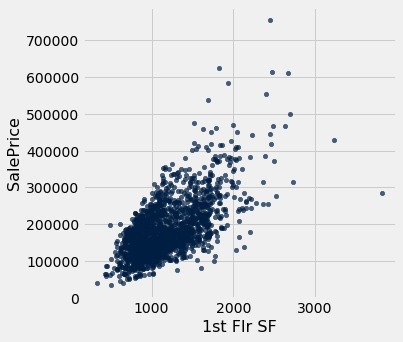

In [5]:
sales.scatter('1st Flr SF', 'SalePrice')

In [6]:
correlation(sales, 'SalePrice', '1st Flr SF')

0.6424662541030225

In [7]:
for label in sales.labels:
    print('Correlation of', label, 'and SalePrice:\t', correlation(sales, label, 'SalePrice'))

Correlation of SalePrice and SalePrice:	 1.0
Correlation of 1st Flr SF and SalePrice:	 0.6424662541030225
Correlation of 2nd Flr SF and SalePrice:	 0.3575218942800824
Correlation of Total Bsmt SF and SalePrice:	 0.652978626757169
Correlation of Garage Area and SalePrice:	 0.6385944852520443
Correlation of Wood Deck SF and SalePrice:	 0.3526986661950492
Correlation of Open Porch SF and SalePrice:	 0.3369094170263733
Correlation of Lot Area and SalePrice:	 0.2908234551157694
Correlation of Year Built and SalePrice:	 0.5651647537135916
Correlation of Yr Sold and SalePrice:	 0.02594857908072111


In [8]:
both_floors = sales.column(1) + sales.column(2)
correlation(sales.with_column('Both Floors', both_floors), 'SalePrice', 'Both Floors')

0.7821920556134877

In [9]:
train, test = sales.split(1001)
print(train.num_rows, 'training and', test.num_rows, 'test instances.')

1001 training and 1001 test instances.


In [10]:
def predict(slopes, row):
    return sum(slopes * np.array(row))

example_row = test.drop('SalePrice').row(0)
print('Predicting sale price for:', example_row)
example_slopes = np.random.normal(10, 1, len(example_row))
print('Using slopes:', example_slopes)
print('Result:', predict(example_slopes, example_row))

Predicting sale price for: Row(1st Flr SF=1207, 2nd Flr SF=0, Total Bsmt SF=1135.0, Garage Area=264.0, Wood Deck SF=0, Open Porch SF=240, Lot Area=9510, Year Built=1962, Yr Sold=2006)
Using slopes: [ 9.52065867  8.58939769 11.48702417  9.50389131  9.09151019  9.86944284
 10.71929443 10.88966608  8.33339346]
Result: 169429.7032316262


In [11]:
print('Actual sale price:', test.column('SalePrice').item(0))
print('Predicted sale price using random slopes:', predict(example_slopes, example_row))

Actual sale price: 147000
Predicted sale price using random slopes: 169429.7032316262


In [12]:
train_prices = train.column(0)
train_attributes = train.drop(0)

def rmse(slopes, attributes, prices):
    errors = []
    for i in np.arange(len(prices)):
        predicted = predict(slopes, attributes.row(i))
        actual = prices.item(i)
        errors.append((predicted - actual) ** 2)
    return np.mean(errors) ** 0.5

def rmse_train(slopes):
    return rmse(slopes, train_attributes, train_prices)

print('RMSE of all training examples using random slopes:', rmse_train(example_slopes))

RMSE of all training examples using random slopes: 68153.56796456952


In [13]:
best_slopes = minimize(rmse_train, start=example_slopes, smooth=True, array=True)
print('The best slopes for the training set:')
Table(train_attributes.labels).with_row(list(best_slopes)).show()
print('RMSE of all training examples using the best slopes:', rmse_train(best_slopes))

The best slopes for the training set:


RMSE of all training examples using the best slopes: 29311.117940347867


In [14]:
test_prices = test.column(0)
test_attributes = test.drop(0)

def rmse_test(slopes):
    return rmse(slopes, test_attributes, test_prices)

rmse_linear = rmse_test(best_slopes)
print('Test set RMSE for multiple linear regression:', rmse_linear)

Test set RMSE for multiple linear regression: 33025.064938240575


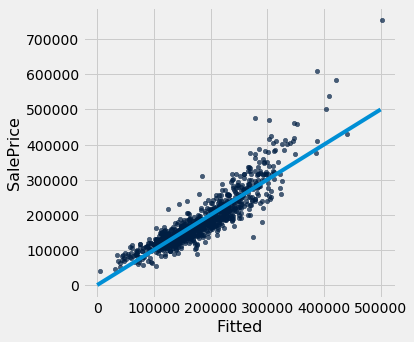

In [15]:
def fit(row):
    return sum(best_slopes * np.array(row))

test.with_column('Fitted', test.drop(0).apply(fit)).scatter('Fitted', 0)
plots.plot([0, 5e5], [0, 5e5]);

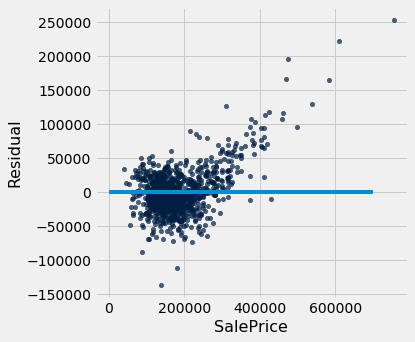

In [16]:
test.with_column('Residual', test_prices-test.drop(0).apply(fit)).scatter(0, 'Residual')
plots.plot([0, 7e5], [0, 0]);

In [17]:
train_nn = train.select(0, 1, 2, 3, 4, 8)
test_nn = test.select(0, 1, 2, 3, 4, 8)
train_nn.show(3)

In [18]:
def distance(pt1, pt2):
    """The distance between two points, represented as arrays."""
    return np.sqrt(sum((pt1 - pt2) ** 2))

def row_distance(row1, row2):
    """The distance between two rows of a table."""
    return distance(np.array(row1), np.array(row2))

def distances(training, example, output):
    """Compute the distance from example for each row in training."""
    dists = []
    attributes = training.drop(output)
    for row in attributes.rows:
        dists.append(row_distance(row, example))
    return training.with_column('Distance', dists)

def closest(training, example, k, output):
    """Return a table of the k closest neighbors to example."""
    return distances(training, example, output).sort('Distance').take(np.arange(k))

example_nn_row = test_nn.drop(0).row(0)
closest(train_nn, example_nn_row, 5, 'SalePrice')

SalePrice | 1st Flr SF | 2nd Flr SF | Total Bsmt SF | Garage Area | Year Built | Distance
137000    | 1176       | 0          | 1158          | 303         | 1958       | 55.0182
146000    | 1150       | 0          | 1150          | 288         | 1961       | 63.6475
126175    | 1163       | 0          | 1162          | 220         | 1955       | 68.1909
157900    | 1188       | 0          | 1188          | 312         | 1962       | 73.9865
150000    | 1144       | 0          | 1169          | 286         | 1956       | 75.1332

In [19]:
def predict_nn(example):
    """Return the majority class among the k nearest neighbors."""
    return np.average(closest(train_nn, example, 5, 'SalePrice').column('SalePrice'))

predict_nn(example_nn_row)

143415.0

In [20]:
print('Actual sale price:', test_nn.column('SalePrice').item(0))
print('Predicted sale price using nearest neighbors:', predict_nn(example_nn_row))

Actual sale price: 147000
Predicted sale price using nearest neighbors: 143415.0


In [21]:
nn_test_predictions = test_nn.drop('SalePrice').apply(predict_nn)
rmse_nn = np.mean((test_prices - nn_test_predictions) ** 2) ** 0.5

print('Test set RMSE for multiple linear regression: ', rmse_linear)
print('Test set RMSE for nearest neighbor regression:', rmse_nn)

Test set RMSE for multiple linear regression:  33025.064938240575
Test set RMSE for nearest neighbor regression: 36067.116043510105


In [22]:
test.with_column('Residual', test_prices-nn_test_predictions).scatter(0, 'Residual')
plots.plot([0, 7e5], [0, 0]);